In [47]:
import os  
a = os.getcwd()
print(a)

c:\Users\ELipt\OneDrive\All Files\Desktop\invest_atlanta_group_1-1


In [48]:
import geopandas as gpd

In [49]:
import math
import pandas as pd


def haversine_miles(lat1, lon1, lat2, lon2):
    R = 3958.8  # miles
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2.0) ** 2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def find_col(df, candidates):
    for c in candidates:
        for col in df.columns:
            col_str = str(col) if col is not None else ''
            if col_str.strip().lower() == c.lower():
                return col
    for c in candidates:
        for col in df.columns:
            col_str = str(col) if col is not None else ''
            if c.lower() in col_str.strip().lower():
                return col
    return None

# Set up BASE path
BASE = r"C:\Users\ELipt\OneDrive\All Files\Desktop\invest_atlanta_group_1-1"

# Load data paths
stadium_path = os.path.join(BASE, "data", "stadium", "stadium_location.csv")
business_path = os.path.join(BASE, "data", "business_records", "Atlanta_Business_License_Records_2025(Food Licenses).csv")

# Basic existence checks to give clearer error messages
if not os.path.exists(stadium_path):
    raise FileNotFoundError(f"Stadium file not found: {stadium_path}")
if not os.path.exists(business_path):
    raise FileNotFoundError(f"Business file not found: {business_path}")

import re

# Read stadium coordinates robustly with multiple fallbacks to avoid OS-level open() errors
stad_lat = stad_lon = None

# 1) Try reading with pandas (handles many CSV variants)
try:
    df_stad = pd.read_csv(stadium_path, header=None, engine='python', encoding='utf-8', dtype=str)
    if not df_stad.empty:
        # Join the first row's non-empty cells and extract numeric tokens
        first_row = df_stad.iloc[0].astype(str).tolist()
        joined = ",".join([s for s in first_row if pd.notna(s) and s.strip() != ""])
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", joined)
        if len(nums) >= 2:
            stad_lat, stad_lon = float(nums[0]), float(nums[1])
except Exception:
    # swallow and proceed to other fallbacks
    pass

# 2) If pandas didn't work, try reading file as binary then decode (avoids some OSError/invalid-argument issues)
if stad_lat is None or stad_lon is None:
    try:
        with open(stadium_path, "rb") as f:
            raw = f.read()
        # Decode safely and remove null bytes that may cause parsing problems
        text = raw.decode("utf-8", errors="replace").replace("\x00", "").strip()
        if not text:
            raise ValueError("Stadium file is empty or contains only null bytes.")
        first_line = text.splitlines()[0]
        parts = [p.strip() for p in re.split(r"[,;\t]", first_line) if p.strip() != ""]
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", first_line)
        if len(parts) >= 2:
            try:
                stad_lat = float(re.findall(r"[-+]?\d*\.\d+|\d+", parts[0])[0])
                stad_lon = float(re.findall(r"[-+]?\d*\.\d+|\d+", parts[1])[0])
            except Exception:
                if len(nums) >= 2:
                    stad_lat, stad_lon = float(nums[0]), float(nums[1])
                else:
                    raise ValueError("Could not parse two numeric coordinates from stadium file.")
        elif len(nums) >= 2:
            stad_lat, stad_lon = float(nums[0]), float(nums[1])
        else:
            raise ValueError("Could not parse stadium coordinates from file content.")
    except OSError as e:
        # Provide a clearer error message if opening the file fails at OS level
        raise OSError(f"Error opening stadium file {stadium_path}: {e}")
    except Exception as e:
        raise RuntimeError(f"Failed to read/parse stadium coordinates: {e}")

# Final sanity check
if stad_lat is None or stad_lon is None:
    raise ValueError(f"Stadium coordinates could not be determined from {stadium_path}.")

# Read business CSV with a fallback if primary encoding/engine fails
try:
    business_df = pd.read_csv(business_path, encoding="latin-1")
except Exception as e:
    print(f"Primary read of business CSV failed: {e}. Retrying with utf-8 and engine='python'...")
    try:
        business_df = pd.read_csv(business_path, encoding="utf-8", engine="python")
    except Exception as e2:
        raise RuntimeError(f"Failed to read business CSV at {business_path}: {e2}")




# Set up column names
biz_lat_col = "latitude"
biz_lon_col = "longitude"

print(f"Stadium location: ({stad_lat}, {stad_lon})")
print(f"Total businesses loaded: {len(business_df)}")


Stadium location: (33.7553276, -84.4031654)
Total businesses loaded: 28135


In [121]:
print("Available columns in business_df:")
print(business_df.columns.tolist())
print("\n")

name_col = find_col(business_df, ["company_name", "business name", "dba", "name", "business", "business_name"])
print(f"Name column: {name_col}")
print(f"Lat column: {biz_lat_col}")
print(f"Lon column: {biz_lon_col}")
print(f"\nTotal businesses before filtering: {len(business_df)}")

# Filter out rows with missing latitude or longitude
business_df[biz_lat_col] = pd.to_numeric(business_df[biz_lat_col], errors="coerce")
business_df[biz_lon_col] = pd.to_numeric(business_df[biz_lon_col], errors="coerce")
valid = business_df.dropna(subset=[biz_lat_col, biz_lon_col])

print(f"Businesses with valid coordinates: {len(valid)}")

distances_list = []
for idx, row in valid.iterrows():
    name = str(row[name_col]).strip() if pd.notna(row[name_col]) else "Unknown"
    
    # Build full address from multiple components
    address_parts = []
    for col in ["address_line1", "street_type", "city", "state", "postal_code"]:
        if col in business_df.columns and pd.notna(row[col]):
            part = str(row[col]).strip()
            if part and part != "nan":
                address_parts.append(part)
    address = " ".join(address_parts) if address_parts else "Unknown"
    
    lat = float(row[biz_lat_col])
    lon = float(row[biz_lon_col])
    miles = haversine_miles(stad_lat, stad_lon, lat, lon)
    business_data = [name, round(miles, 4), address, lat, lon]
    distances_list.append(business_data)
    
# ---- Compute percentile buckets for distances_list ----
# Extract the miles column from distances_list (2nd item in each list)
miles_all = [row[1] for row in distances_list]

# Calculate percentiles
percentiles = pd.Series(miles_all).rank(pct=True) * 100

def distance_bucket(p):
    if p <= 20: return 1
    elif p <= 40: return 2
    elif p <= 60: return 3
    elif p <= 80: return 4
    else: return 5

bucket_list = [distance_bucket(p) for p in percentiles]

#Append bucket to business_data elements in distances_list
for i in range(len(distances_list)):
    distances_list[i].append(bucket_list[i])
    i = i+1
    print(distances_list[i-1])

out_df = pd.DataFrame(distances_list, columns=["business_name", "miles_to_stadium", "address", "latitude", "longitude","bucket_list"])

out_df.to_csv(os.path.join(BASE, "data", "business_records", "distances_to_stadium.csv"), index=False)
print("Saved distances:", out_df.shape[0])



Available columns in business_df:
['license_number', 'company_name', 'company_dba', 'license_classification', '2 or more companies', '# in each license', 'issued_date', 'naics_code', 'naics_name', 'Unnamed: 9', 'predirection', 'address_line1', 'address_line2', 'street_type', 'postdirection', 'unit_suite', 'city', 'state', 'postal_code', 'address_concat', 'address_api', 'longitude', 'latitude', 'disinvested_neighborhood', 'council_district', 'npu']


Name column: company_name
Lat column: latitude
Lon column: longitude

Total businesses before filtering: 28135
Businesses with valid coordinates: 2037
['PreView Restaurant, LLC.', 4.1524, '2221 Peachtree Rd NE Atlanta GA 30309', 33.81458899, -84.39114199, 4]
['Botanico Hospitality Group LLC', 2.1674, '955 W Marietta ST NW Atlanta GA 30318', 33.7841318, -84.41810792, 2]
['FACILITY CONCESSION SERVICE LLC', 3.0523, '1099 AVE ATLANTA GA 30307', 33.76360623, -84.35097038, 3]
['FACILITY CONCESSION SERVICE LLC', 3.0523, '1099 AVE ATLANTA GA 30307'

In [51]:

# Find max and min distances (filter out unrealistic distances > 100 miles)
realistic_df = out_df[out_df['miles_to_stadium'] <= 100]
print(f"Businesses within realistic range (≤100 miles): {len(realistic_df)}")
print(f"Outliers removed: {len(out_df) - len(realistic_df)}")

max_idx = realistic_df['miles_to_stadium'].idxmax()
min_idx = realistic_df['miles_to_stadium'].idxmin()

max_distance = realistic_df.loc[max_idx]
min_distance = realistic_df.loc[min_idx]

print("\n" + "="*80)
print("CLOSEST BUSINESS TO STADIUM:")
print("="*80)
print(f"Name: {min_distance['business_name']}")
print(f"Distance: {min_distance['miles_to_stadium']} miles")
print(f"Address: {min_distance['address']}")

print("\n" + "="*80)
print("FARTHEST BUSINESS FROM STADIUM (within realistic range):")
print("="*80)
print(f"Name: {max_distance['business_name']}")
print(f"Distance: {max_distance['miles_to_stadium']} miles")
print(f"Address: {max_distance['address']}")


Businesses within realistic range (≤100 miles): 2030
Outliers removed: 7

CLOSEST BUSINESS TO STADIUM:
Name: PUBLIC HOUSE 28, LLC
Distance: 0.0346 miles
Address: 10 DR ATLANTA GA 30314

FARTHEST BUSINESS FROM STADIUM (within realistic range):
Name: GIO'S CHCKN AMALFITANO, LLC
Distance: 25.5463 miles
Address: 204 Bluff Creek Dr. Woodstock GA 30188


In [52]:

# Find all businesses 25 miles or higher from stadium
far_businesses = realistic_df[realistic_df['miles_to_stadium'] >= 25].sort_values('miles_to_stadium', ascending=False)

print("\n" + "="*80)
print(f"BUSINESSES 25 MILES OR HIGHER FROM STADIUM ({len(far_businesses)} total)")
print("="*80 + "\n")

for idx, (_, row) in enumerate(far_businesses.iterrows(), 1):
    print(f"{idx}. {row['business_name']}")
    print(f"   Distance: {row['miles_to_stadium']} miles")
    print(f"   Address: {row['address']}")
    print()



BUSINESSES 25 MILES OR HIGHER FROM STADIUM (1 total)

1. GIO'S CHCKN AMALFITANO, LLC
   Distance: 25.5463 miles
   Address: 204 Bluff Creek Dr. Woodstock GA 30188



Closest business: PUBLIC HOUSE 28, LLC — 0.0346 miles
Farthest business: GIO'S CHCKN AMALFITANO, LLC — 25.5463 miles
Farthest business appears to be Gio's (matches name containing 'gio').


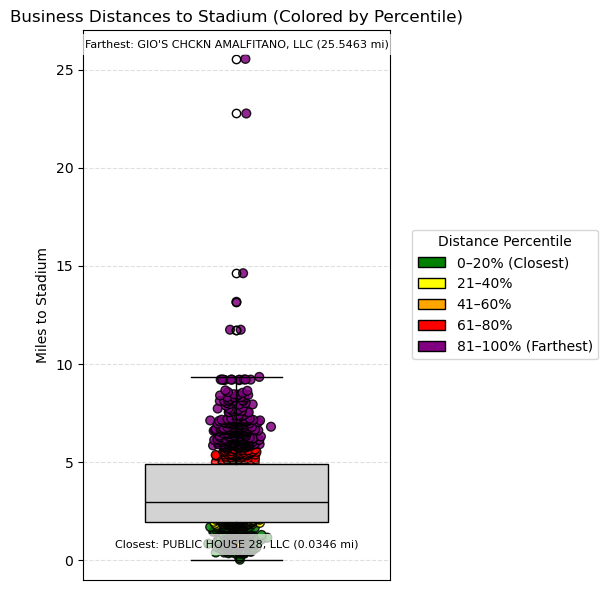

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from matplotlib.patches import Patch

# Ensure `out_df` is available; fallback to CSV if not
if 'out_df' not in globals():
    try:
        out_df = pd.read_csv(os.path.join(BASE, 'data', 'business_records', 'distances_to_stadium.csv'))
    except Exception as e:
        print('Could not find `out_df` and failed to load from CSV:', e)
        raise

# Filter unrealistic outliers (<= 100 miles) then sort
realistic_df = out_df[out_df['miles_to_stadium'] <= 100].copy()
if realistic_df.empty:
    print("No realistic data (<=100 miles) available to plot.")
else:
    df_sorted = realistic_df.sort_values('miles_to_stadium').reset_index(drop=True)

    closest = df_sorted.iloc[0]
    farthest = df_sorted.iloc[-1]
    print(f"Closest business: {closest['business_name']} — {closest['miles_to_stadium']} miles")
    print(f"Farthest business: {farthest['business_name']} — {farthest['miles_to_stadium']} miles")

    far_name = str(farthest['business_name']).lower() if pd.notna(farthest['business_name']) else ''
    if 'gio' in far_name:
        print("Farthest business appears to be Gio's (matches name containing 'gio').")
    else:
        print("Farthest business does not appear to be Gio's.")

    # ---- Percentile Buckets ----
    df_sorted['percentile'] = df_sorted['miles_to_stadium'].rank(pct=True) * 100

    def percentile_bucket(p):
        if p <= 20: return 1
        elif p <= 40: return 2
        elif p <= 60: return 3
        elif p <= 80: return 4
        return 5

    df_sorted['distance_percentile_bucket'] = df_sorted['percentile'].apply(percentile_bucket)

    # Data for plotting
    y = df_sorted['miles_to_stadium'].astype(float).tolist()

    plt.figure(figsize=(6, 6))  # extra space for legend on right

    plt.boxplot(
        y, vert=True, widths=0.6, patch_artist=True,
        boxprops=dict(facecolor='lightgray', color='black'),
        medianprops=dict(color='black')
    )

    x_jitter = np.random.normal(loc=1.0, scale=0.03, size=len(y))

    color_map = {
        1: 'green',
        2: 'yellow',
        3: 'orange',
        4: 'red',
        5: 'purple'
    }

    plot_colors = df_sorted['distance_percentile_bucket'].map(color_map).tolist()

    plt.scatter(x_jitter, y, c=plot_colors, s=40, alpha=0.85, edgecolor='black')

    # Legend moved outside plot (right side)
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', label='0–20% (Closest)'),
        Patch(facecolor='yellow', edgecolor='black', label='21–40%'),
        Patch(facecolor='orange', edgecolor='black', label='41–60%'),
        Patch(facecolor='red', edgecolor='black', label='61–80%'),
        Patch(facecolor='purple', edgecolor='black', label='81–100% (Farthest)')
    ]
    plt.legend(handles=legend_elements, title="Distance Percentile",
               bbox_to_anchor=(1.05, .65), loc='upper left')

    # Highlight Gio in orange (NO legend)
    gio_mask = df_sorted['business_name'].astype(str).str.lower().str.contains('gio', na=False)
    if gio_mask.any():
        gi = gio_mask[gio_mask].index[0]
        plt.scatter(
            1.0 + np.random.normal(0, 0.02),
            y[gi], c='orange', s=70, edgecolor='black', marker='*', linewidths=1.2
        )

    plt.ylabel('Miles to Stadium')
    plt.title('Business Distances to Stadium (Colored by Percentile)')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    ymin, ymax = -1, 27
    plt.ylim(ymin, ymax)

    def short_label(s, width=30):
        try: return textwrap.shorten(str(s), width=width, placeholder='...')
        except: return str(s)

    try:
        if ymin <= closest['miles_to_stadium'] <= ymax:
            plt.text(
                1.0, closest['miles_to_stadium'] + 0.6,
                f"Closest: {short_label(closest['business_name'])} ({closest['miles_to_stadium']} mi)",
                ha='center', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
            )
        if ymin <= farthest['miles_to_stadium'] <= ymax:
            plt.text(
                1.0, farthest['miles_to_stadium'] + 0.6,
                f"Farthest: {short_label(farthest['business_name'])} ({farthest['miles_to_stadium']} mi)",
                ha='center', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
            )
    except:
        pass

    plt.xticks([])
    plt.tight_layout()
    plt.show()


Closest business: PUBLIC HOUSE 28, LLC — 0.0346 miles
Farthest business: GIO'S CHCKN AMALFITANO, LLC — 25.5463 miles
Farthest business appears to be Gio's (matches name containing 'gio').


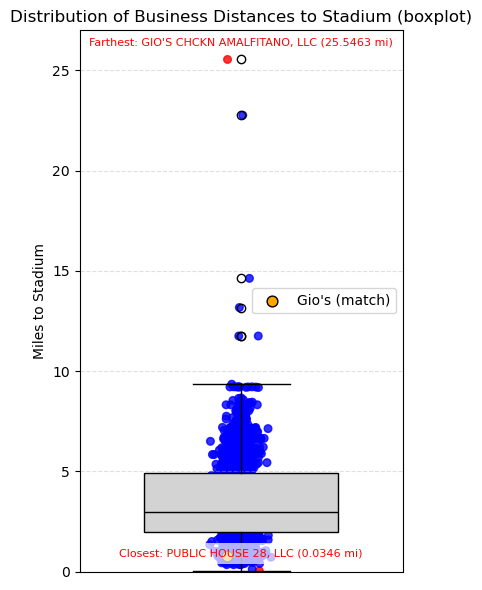

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Ensure `out_df` is available; fallback to CSV if not
if 'out_df' not in globals():
    try:
        out_df = pd.read_csv(os.path.join(BASE, 'data', 'business_records', 'distances_to_stadium.csv'))
    except Exception as e:
        print('Could not find `out_df` and failed to load from CSV:', e)
        raise

# Filter unrealistic outliers (keep <= 100 miles) then sort from closest to farthest
realistic_df = out_df[out_df['miles_to_stadium'] <= 100].copy()
if realistic_df.empty:
    print('No realistic data (<=100 miles) available to plot.')
else:
    df_sorted = realistic_df.sort_values('miles_to_stadium').reset_index(drop=True)
    # Identify farthest and closest
    closest = df_sorted.iloc[0]
    farthest = df_sorted.iloc[-1]
    print(f"Closest business: {closest['business_name']} — {closest['miles_to_stadium']} miles")
    print(f"Farthest business: {farthest['business_name']} — {farthest['miles_to_stadium']} miles")
    # Check whether farthest looks like Gio's
    far_name = str(farthest['business_name']).lower() if pd.notna(farthest['business_name']) else ''
    if 'gio' in far_name:
        print("Farthest business appears to be Gio's (matches name containing 'gio').")
    else:
        print("Farthest business does not appear to be Gio's.")

    # Data for plotting
    y = df_sorted['miles_to_stadium'].astype(float).tolist()

    plt.figure(figsize=(4,6))

    # Boxplot (single category)
    plt.boxplot(y, vert=True, widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='lightgray', color='black'),
                medianprops=dict(color='black'))

    # Overlay individual points with slight horizontal jitter so we can see distribution
    x_jitter = np.random.normal(loc=1.0, scale=0.03, size=len(y))
    # Color endpoints red, others blue
    colors = ['red' if i == 0 or i == len(y) - 1 else 'blue' for i in range(len(y))]
    plt.scatter(x_jitter, y, c=colors, s=30, alpha=0.8)

    # Highlight Gio specifically if present anywhere
    gio_mask = df_sorted['business_name'].astype(str).str.lower().str.contains('gio', na=False)
    if gio_mask.any():
        gio_idx = gio_mask[gio_mask].index.tolist()
        # annotate up to first Gio match
        gi = gio_idx[0]
        plt.scatter(1.0 + np.random.normal(0, 0.02), y[gi], c='orange', s=60, edgecolor='k', label="Gio's (match)")
        plt.legend()

    plt.ylabel('Miles to Stadium')
    plt.title('Distribution of Business Distances to Stadium (boxplot)')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # Constrain y-axis for interpretability (0-30 miles)
    ymin, ymax = 0, 27
    plt.ylim(ymin, ymax)

    # Helper to shorten long names
    def short_label(s, width=30):
        try:
            return textwrap.shorten(str(s), width=width, placeholder='...')
        except Exception:
            return str(s)

    # Place labels inside the plot area (centered at x=1.0) so they don't go off screen
    try:
        if ymin <= closest['miles_to_stadium'] <= ymax:
            lbl = f"Closest: {short_label(closest['business_name'], 30)} ({closest['miles_to_stadium']} mi)"
            plt.text(1.0, closest['miles_to_stadium'] + 0.6, lbl, ha='center', va='bottom', fontsize=8, color='red',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        if ymin <= farthest['miles_to_stadium'] <= ymax:
            lbl = f"Farthest: {short_label(farthest['business_name'], 30)} ({farthest['miles_to_stadium']} mi)"
            plt.text(1.0, farthest['miles_to_stadium'] + 0.6, lbl, ha='center', va='bottom', fontsize=8, color='red',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    except Exception:
        pass

    plt.xticks([])  # remove x-ticks since this is a single-category boxplot
    plt.tight_layout()
    plt.show()
